## Label drift detector

This notebook follows the example from [river](https://riverml.xyz/0.11.1/examples/concept-drift-detection/).
However, instead of using the river library directly, it detects drift using 
`drifting`. Also, we don't adapt to new domains while serving the detector 
without fitting it again first. 

Let's prepare the data that will imitate the labels

In [2]:
import sys 
sys.path.append("../../") # Adding path to project root for this specific notebook

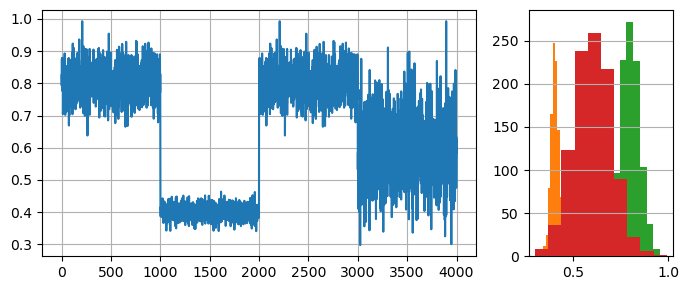

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Generate data for 3 distributions
random_state = np.random.RandomState(seed=42)
dist_a = random_state.normal(0.8, 0.05, 1000)
dist_b = random_state.normal(0.4, 0.02, 1000)
dist_c = random_state.normal(0.6, 0.1, 1000)

# Concatenate data to simulate a data stream with 2 drifts
stream = np.concatenate((dist_a, dist_b, dist_a, dist_c))

# Auxiliary function to plot the data
def plot_data(dist_a, dist_b, dist_c, drifts=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    ax1.plot(stream, label='Stream')
    ax2.grid(axis='y')
    ax2.hist(dist_a, label=r'$dist_a$')
    ax2.hist(dist_b, label=r'$dist_b$')
    ax2.hist(dist_a, label=r'$dist_a$')
    ax2.hist(dist_c, label=r'$dist_c$')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')
    plt.show()

plot_data(dist_a, dist_b, dist_c)


train_data = dist_a
test_data = stream

We can see 3 kinds of predictions. We will fit the drift detector on the first 
distribution, and test it on the two following, putting the training data
in between.

We train the model:

In [4]:

from drifting import DriftingClient, DriftType

client = DriftingClient()
detector_name = "LabelDriftDetector"

client.fit(train_data, drift_type=DriftType.LABEL, detector_name=detector_name)

Load the model after training:

In [16]:
client.load(detector_name=detector_name)

ReadTimeout: HTTPConnectionPool(host='localhost', port=8080): Read timed out. (read timeout=10)

Detect drift sending the labels one by one: 

Change detected at index 29
Change detected at index 30
Change detected at index 46
Change detected at index 47
Change detected at index 49
Change detected at index 50
Change detected at index 51
Change detected at index 52
Change detected at index 428
Change detected at index 534
Change detected at index 535
Change detected at index 536
Change detected at index 537
Change detected at index 541
Change detected at index 892
Change detected at index 893
Change detected at index 894
Change detected at index 895
Change detected at index 896
Change detected at index 897
Change detected at index 898
Change detected at index 899
Change detected at index 900
Change detected at index 901
Change detected at index 902
Change detected at index 903
Change detected at index 904
Change detected at index 905
Change detected at index 907
Change detected at index 908
Change detected at index 909
Change detected at index 911
Change detected at index 912
Change detected at index 913
Change detected at ind

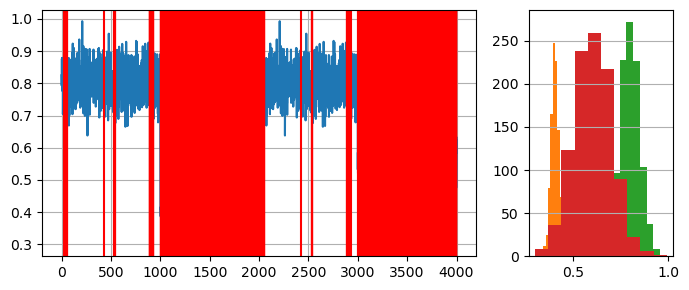

In [14]:

drifts = []
for i, val in enumerate(test_data):
    val = np.array([val])
    is_drift, stat_val = client.predict(val, drift_type=DriftType.LABEL, detector_name=detector_name)
    # print(response)
    if is_drift:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i}')
        drifts.append(i)
    break
plot_data(dist_a, dist_b, dist_c, drifts)

In [18]:
val

array([0.82483571])